## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2019.

# Assignment 1, Task 3: Dimensionality Reduction

This task is devoted to dimensionality reduction. How to map high-dimensional data into low-dimensional space is an interesting topic in the machine learning field. It is related to another hot topic -- unsupervised learning. In this section, you are going to learn two different methods for this dimensionality reduction.

* Principal Component Analysis (PCA)
* t-Distributed Stochastic Neighbor Embedding (t-SNE) 

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from utils.cifar_utils import load_data

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load Data

We will use the CIFAR-10 dataset.

In [2]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()
X_train = X_train.reshape([50000,3,32,32]).transpose((0,2,3,1))
X_test = X_test.reshape([10000,3,32,32]).transpose((0,2,3,1))
# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Data organizations:
# Train data: 49000 samples from original train set: 1~49000
# Validation data: 1000 samples from original train set: 49000~50000
# Test data: 10000 samples from original test set: 1~10000
# Development data (for gradient check): 100 from the train set: 1~49000 #TODOTA is this 100 or 1000?
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
(49000, 32, 32, 3) (1000, 32, 32, 3) (10000, 32, 32, 3) (100, 32, 32, 3)
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
Development data shape: (100, 32, 32, 3)
Development data shape (100,)


## Part 1: Principal Component Analysis (PCA)

<span style="color:red"><strong>TODO</strong></span>: You have to complete the code in **./utils/features/pca.py**.

### Naive PCA

In [3]:
from utils.features.pca import pca_naive

X_patch = X_train[:,:,:,0]
X_patch = np.reshape(X_patch, (X_patch.shape[0], -1))
print(X_patch.shape)

(49000, 1024)


In [4]:
# Start PCA
K = 300
P, T = pca_naive(X_patch, K)

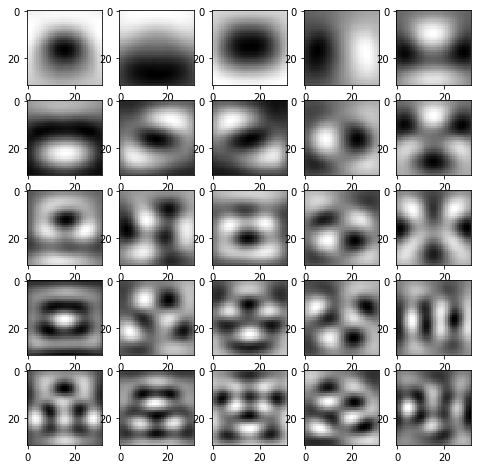

In [5]:
# Show principle components of P using a 5x5 subplot
# Visualize P
r = 5
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = np.reshape(P[r*i+j], [32,32])
        axarr[i][j].imshow(img, cmap="gray")

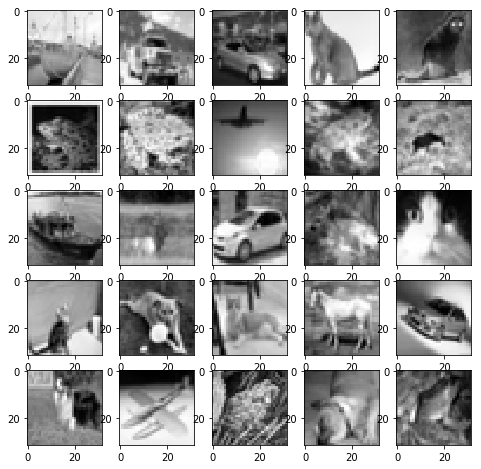

In [6]:
# Select a small set of images for test
num_training = 49000
num_pca = 25
mask = np.random.choice(num_training, num_pca, replace=False)
X_pca = X_train[mask,:,:,0]

# Visualize one channel of images 
r = 5
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = X_pca[r*i+j]
        axarr[i][j].imshow(img, cmap="gray")

(300,)


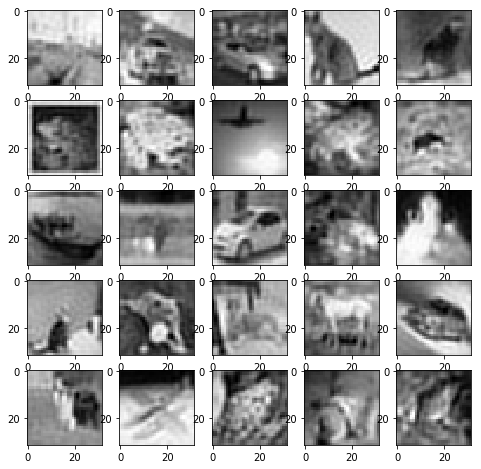

In [7]:
# Test your result
# Reduce dimension with P
X_features = []
for n in range(num_pca):
    img = X_pca[n]
    feature = np.dot(P, np.reshape(img, (-1,)))
    X_features.append(feature)
print(feature.shape)

# Reconstruct image
X_recon = []
for n in range(num_pca):
    feature = X_features[n]
    img = np.reshape(np.dot(feature, P), (32,32))
    X_recon.append(img)

# Visualize results
r = 5
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = X_recon[r*i+j]
        axarr[i][j].imshow(img, cmap="gray")

### PCA + Neural network

<span style="color:red"><strong>TODO</strong></span>: Use PCA to preprocess images before training a neural network: 

1. Do PCA preprocessing on each channel of the original image separately.
2. Stack PCA features from three channels into one vector, and use that vector as an input for MLP.
3. Train the MLP and show the results. 

In [8]:
print(X_train.shape)

(49000, 32, 32, 3)


In [9]:
from utils.train_funcs import train, test
from utils.classifiers.mlp import MLP
## TODO: pca preprocessing -> mlp classification

D = K * 3

def trans(X):
    num = X.shape[0]
    X_feature = np.zeros([num, D])
    for i in range(num):
        feature = []
        img = X[i]
        for j in range(3):
            feature = np.concatenate((feature, np.dot(P, np.reshape(img[:,:,j], (-1,))))) 
        X_feature[i, ] = feature
    return X_feature

X_train_feature = trans(X_train)
X_val_feature = trans(X_val)
X_test_feature = trans(X_test)


model = MLP(input_dim=D, hidden_dims=[100, 100], num_classes=10, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 1e-2
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train_feature, y_train, X_val_feature, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
ans = test(model, X_test_feature, y_test)

number of batches for training: 98
epoch 1: valid acc = 0.172, new learning rate = 0.0095
epoch 2: valid acc = 0.177, new learning rate = 0.009025
epoch 3: valid acc = 0.184, new learning rate = 0.00857375
epoch 4: valid acc = 0.245, new learning rate = 0.0081450625
epoch 5: valid acc = 0.272, new learning rate = 0.007737809374999999
epoch 6: valid acc = 0.266, new learning rate = 0.007350918906249998
epoch 7: valid acc = 0.252, new learning rate = 0.006983372960937498
epoch 8: valid acc = 0.313, new learning rate = 0.006634204312890623
epoch 9: valid acc = 0.375, new learning rate = 0.006302494097246091
epoch 10: valid acc = 0.387, new learning rate = 0.005987369392383786
test acc: 0.4123


<span style="color:red"><strong>TODO</strong></span>: Plot training, validation and test set accuracy.

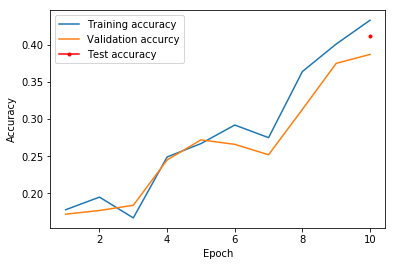

In [10]:
## TODO:
# plot the accuracy history
L = []
for i in range(num_epoch):
    L.append(i+1)
plt.plot(L, train_acc_hist, label = 'Training accuracy')
plt.plot(L, val_acc_hist, label = 'Validation accurcy')
plt.plot(10, ans, marker='o', markersize=3, color='red', label = 'Test accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Part 2: t-SNE (optional, bonus +10 points)

t-SNE is is a machine learning algorithm for nonlinear dimensionality reduction developed by Geoffrey Hinton and Laurens van der Maaten. It is also a good way of visualizing high-dimensional data in 2D. We show its application for CIFAR10. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

<p style="line-height: 1.2;">[1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.</p>
<p style="line-height: 1.2;">[2] Adaptive learning rate scheme by Jacobs https://www.willamette.edu/~gorr/classes/cs449/Momentum/deltabardelta.html</p>
<p style="line-height: 1.2;">[3] http://cs.stanford.edu/people/karpathy/cnnembed/</p>
<p style="line-height: 1.2;">[4] How to Use t-SNE Effectively, with examples.
 https://distill.pub/2016/misread-tsne</p>

In [11]:
from utils.features.tsne import tsne

#### tSNE of original data

In [12]:
random_select = np.random.choice(10000, 500, replace=False)
X = X_test[random_select,:,:,0].reshape(500,1024).astype('float')/255.0
tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

2.495864442078914
The 100 th loop cost: 13.595804820577428, computation time: 1.5268559455871582
The 200 th loop cost: 1.1331163156207698, computation time: 3.0835928916931152
The 300 th loop cost: 1.1290082244398718, computation time: 4.754049062728882
The 400 th loop cost: 1.1289612211064248, computation time: 6.544408082962036
The 500 th loop cost: 1.1289611365032461, computation time: 8.827629089355469
The 600 th loop cost: 1.128961136345094, computation time: 11.736678838729858
The 700 th loop cost: 1.1289611363447434, computation time: 13.607712984085083
The 800 th loop cost: 1.12896113634474, computation time: 15.20441484451294
The 900 th loop cost: 1.1289611363447405, computation time: 16.75439190864563
The 1000 th loop cost: 1.1289611363447403, computation time: 18.303951740264893
it takes 18.916574954986572 seconds


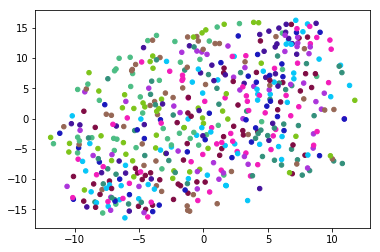

In [13]:
## visualize tSNE of original data
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#### tSNE of data after two hidden layers

Do visualization of the tSNE of data after going through MLP. In the visualization result, you should find that in comparison with the tSNE of original data where all data points mess up with each other. While the tSNE of data after two-layer networks would be shown as multiple clusters in a 2D panel.

In [14]:
X_train, y_train, X_test, y_test = load_data()
num_training = 49000
num_validation = 1000
num_dev = 100
X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]
X_train = X_train[:num_training, :]
y_train = y_train[:num_training]
mean_image = np.mean(X_train, axis=0)
X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image




# Define MLP model
model = MLP(input_dim=3072, hidden_dims=[100], num_classes=10, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 245
epoch 1: valid acc = 0.381, new learning rate = 0.00095
epoch 2: valid acc = 0.457, new learning rate = 0.0009025
epoch 3: valid acc = 0.457, new learning rate = 0.000857375
epoch 4: valid acc = 0.459, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.5, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.497, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.505, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.517, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.494, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.489, new learning rate = 0.0005987369392383785
test acc: 0.503


0.503

<span style="color:red"><strong>TODO</strong></span>: Do visualization of the tSNE of data after going through MLP. 

In [15]:
# run tSNE
X = X_test[random_select]
tic = time.time()
# TODO:
# You need to first go through two hidden layers.
out = model.tsne(X)
Y = tsne(out, low_dim=2, perplexity=30.0)
# End TODO
print("it takes {} seconds".format(time.time()-tic))

/Users/runzhongzhang/Desktop/Courses/DL/Homework/HW1/e4040-201Ffall-assignment1-rz2431/utils/features/tsne.py:15: RuntimeWarning: divide by zero encountered in log
  H = -np.dot(np.log(P), P)


2.2889181891914485
The 100 th loop cost: 13.288492246725891, computation time: 1.8906309604644775
The 200 th loop cost: 0.8341459526258507, computation time: 3.6392509937286377
The 300 th loop cost: 0.8097184225490145, computation time: 5.385445833206177
The 400 th loop cost: 0.806571804581798, computation time: 7.1314239501953125
The 500 th loop cost: 0.8058983105502353, computation time: 8.875380992889404
The 600 th loop cost: 0.8056353678790019, computation time: 10.62879991531372
The 700 th loop cost: 0.805504759276794, computation time: 12.38227391242981
The 800 th loop cost: 0.805431540164672, computation time: 14.136883020401001
The 900 th loop cost: 0.8053874296491633, computation time: 15.879727125167847
The 1000 th loop cost: 0.8053590158289418, computation time: 18.336102962493896
it takes 18.93172311782837 seconds


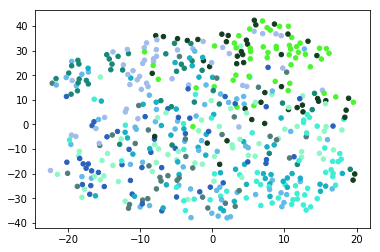

In [16]:
# TODO:
# visualize tSNE 2D representation of data after two hidden layers
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

<span style="color:red"><strong>TODO</strong></span>: Try tuning the parameters of tSNE, do visualization of the new tSNE of data.

In [17]:
# TODO:
# Tune the parameter, show the results.
# run tSNE
X = X_test[random_select]
tic = time.time()
# TODO:
# You need to first go through two hidden layers.
out = model.tsne(X)
Y = tsne(out, low_dim=2, perplexity=40.0)
# End TODO

print("it takes {} seconds".format(time.time()-tic))

2.477422303793005
The 100 th loop cost: 12.610663005820287, computation time: 1.982530117034912
The 200 th loop cost: 0.7544188322262373, computation time: 3.7523581981658936
The 300 th loop cost: 0.7421900693821684, computation time: 5.868483066558838
The 400 th loop cost: 0.74150462621729, computation time: 7.376928091049194
The 500 th loop cost: 0.7414590388607315, computation time: 8.907005310058594
The 600 th loop cost: 0.7414539740149888, computation time: 10.428126335144043
The 700 th loop cost: 0.7414533376384322, computation time: 12.159412145614624
The 800 th loop cost: 0.7414532546471861, computation time: 13.96629810333252
The 900 th loop cost: 0.741453243607059, computation time: 15.817654132843018
The 1000 th loop cost: 0.7414532421247119, computation time: 17.354133129119873
it takes 18.041391134262085 seconds


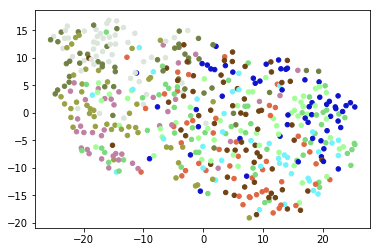

In [18]:
# TODO:
# visualize tSNE 2D representation of data after two hidden layers
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()